In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
import numpy as np
import random
import os
import pandas as pd
from numpy import floor
from numpy.random import shuffle
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab
import torch.nn.functional as F
from collections import Counter
from functools import partial
from ast import literal_eval

In [ ]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = pd.read_csv('Sample.csv', converters={'summary_clean': literal_eval, 'bill_clean': literal_eval})

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Cleaned_Summaries_And_Bills.csv', converters={'summary_clean': literal_eval, 'bill_clean': literal_eval})

In [ ]:
fake_data = pd.DataFrame({'bill_clean':[['<sos>', 'make', 'all', 'drugs', 'legal', '<eos>']], 'summary_clean':[['<sos>', 'make', 'drugs', 'legal', '<eos>']]})
fake_data.head()

,bill_clean,summary_clean
0,"[<sos>, make, all, drugs, legal, <eos>]","[<sos>, make, drugs, legal, <eos>]"


In [ ]:
def compression(df):
    return np.mean(df.summary_clean.apply(len) / df.bill_clean.apply(len))

def trim_dataset(df, bottom_k_pct, top_k_pct):
    '''
    Remove the top and bottom n% records from the bills and summaries.
    Expects tokenized and cleaned dataset.
    Pass in pct as decimals.
    '''
    df['summary_length'] = df.summary_clean.apply(lambda x: len(x))
    df['bill_length'] = df.bill_clean.apply(lambda x: len(x))
    df['summary_rank'] = df.summary_length.rank(pct=True)
    df['bill_rank'] = df.bill_length.rank(pct=True)
    cut_df = df[(df.summary_rank >= bottom_k_pct) & (df.summary_rank <= top_k_pct) & (
        df.bill_rank >= bottom_k_pct) & (df.bill_rank <= top_k_pct) & (df.summary_length <= df.bill_length)]

    print('Cut ' + str(df.shape[0] - cut_df.shape[0]) + ' records.')
    print('Count of records remaining: ', cut_df.shape[0])
    print(f'New min summary length is {cut_df.summary_length.min()}')
    print(f'New max summary length is {cut_df.summary_length.max()}')
    print(f'New min bill length is {cut_df.bill_length.min()}')
    print(f'New max bill length is {cut_df.bill_length.max()}')
    print(f'Compression of summaries to bills is {compression(cut_df)}')
    del cut_df['bill_length']
    del cut_df['summary_length']
    del cut_df['summary_rank']
    del cut_df['bill_rank']
    return cut_df

In [ ]:
sample = trim_dataset(df, 0, .03)

Cut 499 records.
Count of records remaining:  1
New min summary length is 17
New max summary length is 17
New min bill length is 160
New max bill length is 160
Compression of summaries to bills is 0.10625


In [ ]:
def split(data, training_size, testing_size, valid_size, shuffle_data=True):
    ''' Takes in a pandas dataframe as data. Returns three BillsDataset objects'''
    assert training_size + testing_size + \
        valid_size == 1, 'Split sizes should sum to 1'

    def split_index(size, index_length):
        '''Converts decimal to # of samples to take'''
        return int(floor(size * index_length))
    # Split into training / testing / validation sets, assign as attributes.
    indices = list(range(len(data)))

    train_split = split_index(training_size, len(indices))
    test_split = split_index(testing_size, len(indices))

    if shuffle_data:
        shuffle(indices)

    training_data = data.iloc[indices[0:train_split]]
    test_data = data.iloc[indices[train_split:train_split + test_split]]
    validate_data = data.iloc[indices[train_split + test_split:]]

    return (BillsDataset(training_data, 'summary_clean', 'bill_clean'),
            BillsDataset(test_data, 'summary_clean', 'bill_clean'),
            BillsDataset(validate_data, 'summary_clean', 'bill_clean'))

In [ ]:
class BillsDataset(Dataset):
    """
    Dataset for Congressional Bills
    Adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    and from https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb.
    """

    def __init__(self, df, summaries_col, bills_col, transform=None):
        self.data = df.reset_index(drop=True)
        self.labels = summaries_col
        self.texts = bills_col
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        summary = self.data.loc[idx, self.labels]
        bill = self.data.loc[idx, self.texts]

        sample = {'summary': summary, 'bill': bill}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [ ]:
# train, test, valid sizes, respectively
train, test, validate = split(fake_data, 1, 0, 0)

In [ ]:
def build_vocab(training_data, summary_col='summary', bill_col='bill', summaries=True, bills=True):
    '''
    Builds a Vocab object for a Dataset object.
    If default BillsDataset object, summary and bill are dict keys.
    '''
    # Here I used a single counter for both bills and summaries
    # Since we don't want to limit the vocab
    # Which seems right but I have no idea
    counter_words = Counter()

    for index in range(len(training_data)):
        example = training_data[index]
        if summaries:
          counter_words.update(example[summary_col])
        if bills:
          counter_words.update(example[bill_col])

    return Vocab(counter_words)

In [ ]:
vocab = build_vocab(train, 'summary','bill')
print(f'Vocab size is {len(vocab)}')

Vocab size is 8


In [ ]:
def get_dataloaders(batch_size, vocab, max_summary_length, max_bill_length, **kwargs):
    '''
    kwargs for training_data:, test_data:, and validation_data:.
    Returns dict of dataloaders based on arg name input
    '''
    dataloaders = {}
    # Set params for the collate function
    # uses the max length of any bill and summary across the entire data set
    collate_fn = partial(
        collate_bills_fn, vocab=vocab, max_summary_length=max_summary_length, max_bill_length=max_bill_length)

    for dataset_name, data in kwargs.items():
        dataloaders[dataset_name] = DataLoader(
            data, batch_size=batch_size,
            shuffle=True, collate_fn=collate_fn)

    return dataloaders


def collate_bills_fn(batch, vocab, max_summary_length=512, max_bill_length=2048):
    '''
    Collates the batches into the dataloader. Pads unequal lengths with zeros
    based on the max lengths given.
    '''
    labels = []
    texts = []
    for idx, text_dict in enumerate(batch):
        # Get the label and the text
        label = text_dict['summary']
        text = text_dict['bill'][::-1]
        # Output for the sample
        label_vectors = []
        text_vectors = []
        # Check lengths; see how much to pad
        label_length = len(label)
        text_length = len(text)
        labels_to_pad = max_summary_length - label_length
        text_to_pad = max_bill_length - text_length

        if label_length < max_summary_length:
            label.extend(['<pad>'] * labels_to_pad)
            # label_vectors = F.pad(label_vectors, (0, 0, 0, labels_to_pad))
        if text_length < max_bill_length:
            text.extend(['<pad>'] * text_to_pad)
            # text_vectors = F.pad(text_vectors, (0, 0, 0, text_to_pad))label_vectors = []

        for word in label:
            label_vectors.append(vocab.stoi[word])
        for word in text:
            text_vectors.append(vocab.stoi[word])


        labels.append(torch.LongTensor(label_vectors))
        texts.append(torch.LongTensor(text_vectors))
    # Returns shape of (batch size, max_summary (or bill)_length) for each
    return (torch.stack(labels), torch.stack(texts))

In [ ]:
# This results in (number of samples in each set / batch size) tuples (or iteration steps) of size (batch size, max length)
# So if size of training is 15, and batch size is 5, enumerating through dataloader will have 3 steps of inputting label (batch size, summary_length) and text (batch size, bill length)
dataloaders_dict = get_dataloaders(1, vocab, 5, 6, train_data=train,)

In [ ]:
l, f = next(iter(dataloaders_dict['train_data']))
# print(l, [vocab.itos[x] for x in l.squeeze(0)])
# print(f, [vocab.itos[x] for x in f.squeeze(0)])
print(l)

tensor([[3, 6, 4, 5, 2]])


In [ ]:
def build_glove(vocab):
  '''
  Return the pretrained embeddings for the vocab words.
  '''
  # https://nlp.stanford.edu/projects/glove/
  VECTORS_CACHE_DIR = './.vector_cache'
  glove = GloVe(name='6B', cache=VECTORS_CACHE_DIR)
  glove_vectors = glove.get_vecs_by_tokens(vocab.itos)
  return glove_vectors

In [ ]:
glove_vecs = build_glove(vocab)
# glove_vecs will be size (vocab_size, 300)

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 pretrained_embeddings,
                 device,
                 freeze_glove=False,
                 ):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # may have to adjust the padding_idx?
        self.embedding = nn.Embedding.from_pretrained(
            pretrained_embeddings, padding_idx=1, freeze=freeze_glove)

        self.rnn = nn.LSTM(self.input_size, self.hidden_size, num_layers=4)

    def forward(self, text):
      '''
      Text size is batch size, bill length
      '''
      # Embedded size is sequence length, batch size, glove vecs size
      embedded = self.embedding(text).view(-1, len(text), 300)
      # outputs is size (sequence length, batch_size, hidden_size)
      outputs, (hidden, cell) = self.rnn(embedded)
      # each of these are size (1, batch_size, hidden_size)
      return hidden, cell

In [ ]:
encoder = Encoder(300, 512, glove_vecs, DEVICE).to(DEVICE)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, pretrained_embeddings, device, freeze_glove=False):
        super().__init__()

        # output dim should equal vocab size
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(300, hidden_dim, num_layers=4)
        self.fc_out = nn.Linear(hidden_dim, output_dim).to(device)
        # dim=1 applies LogSoftmax across rows
        # Example:
        # a = torch.Tensor([[1, 1, 1, 1], [5,60,5,25]])
        # b = nn.LogSoftmax(dim=1)
        # b(a)
        self.softmax = nn.LogSoftmax(dim=1)
        self.embedding = nn.Embedding.from_pretrained(
            pretrained_embeddings, freeze=freeze_glove)

    def forward(self, input_word, hidden, cell):
        # print('ANSWER',input_word.size())
        # Input word is initially
        input_word = input_word.unsqueeze(0)
        # print('input: ', input_word.size())
        # print(vocab.itos[input_word])
        # print('hidden: ', hidden.size())
        # print('cell: ', cell.size())
        embedded = self.embedding(input_word)  # .view(len(input), 300, -1)
        # print('embedded_decode: ', embedded.size())
        output, (hidden_new, cell_new) = self.rnn(embedded, (hidden, cell))
        # print('new output: ',output.size())
        # print('new hidden: ', hidden.size())
        # print('new cell: ', cell.size())
        prediction = self.softmax(self.fc_out(output.squeeze(0)))
        # print('new prediction', prediction.size())
        return prediction, hidden_new, cell_new

In [ ]:
decoder = Decoder(len(vocab), 512, glove_vecs, DEVICE)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, label, text):
        batch_size = label.shape[0]
        # print('batch size: ', batch_size)

        label_length = label.shape[1]
        # print('label_length: ', label_length)

        vocab_size = self.decoder.output_dim

        decode_outputs = torch.zeros(label_length, batch_size, vocab_size).to(self.device)
        # print('outputs size: ', outputs.size())

        hidden_enc, cell_enc = self.encoder(text)
        input_word = label[:, 0]
        # print(label.size())

        for t in range(1, label_length):
            # print('input word: ', vocab.itos[input_word[0]])

            output, hidden, cell = self.decoder(input_word, hidden_enc, cell_enc)
            # print('output size: ', output.size())
            # print('outputs: ', outputs.size())
            decode_outputs[t] = output
            # pick next word
            # top_choice = output.argmax(1)
            top_choice = torch.max(output, dim=1)[1]
            # print('predicted word:', ', '.join([vocab.itos[x] for x in top_choice]))
            # Check loss here
            # print('top choice', top_choice)
            # somehow?
            #input_word = top_choice
            input_word = label[:, t]
            hidden_enc = hidden
            cell_enc =  cell
        # print('outputs', outputs.size)
        # print(outputs)
        return decode_outputs

In [ ]:
seq = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)

In [ ]:
adams = optim.Adam(encoder.parameters(), lr=.1)
PAD_TOKEN = vocab.stoi['<pad>']
loss = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN).to(DEVICE)  #ignore_index=0

In [ ]:
def train_an_epoch(model, dataloader, optimizer, loss_function):
    # loss_function = nn.CrossEntropyLoss().to(device)
    model.train()
    log_interval = 50
    
    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        label = label.to(DEVICE)
        text = text.to(DEVICE)
        output = model(label, text)
        output_dim = output.shape[-1]
        # print('initial', output.size())
        # print(label.size())
        output = output.view(-1, output_dim)
        target = label.view(-1)
        # print('output', output.size())
        # print('target', target.size())
        # print('TARGET: ', ' '.join([vocab.itos[x] for x in target]))
        # print('PREDICTED: ', ' '.join([vocab.itos[x] for x in torch.max(output, dim=1)[1]]))
        loss = loss_function(output, target)
        loss.backward()
        # print('step', idx)
      
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'Iteration: {idx}; Loss: {loss:.3f}.')
        

## Training

In [ ]:
def get_score(model, dataloader, loss_function):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for i, (label, text) in enumerate(dataloader):
      label = label.to(DEVICE)
      text = text.to(DEVICE)
      output = model(label, text)
      output_dim = output.shape[-1]
      output = output.view(-1, output_dim)
      target = label.view(-1)

      loss = loss_function(output, target)
      total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something changed
something 

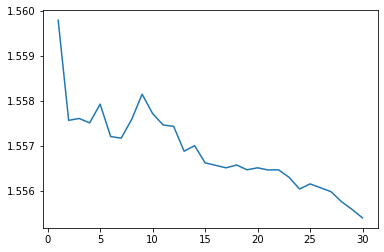

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 30
scores = []
best_lost = float('inf')
for epoch in range(1, EPOCHS + 1):
  train_an_epoch(seq, dataloaders_dict['train_data'], adams, loss)
  score = get_score(seq, dataloaders_dict['train_data'], loss)
  # if score < best_lost:
  #   best_lost = score
  #   torch.save(seq.state_dict(), 's2s-model.pt')
  scores.append(score)
  if epoch % 100 == 0:
    print(f'epoch {epoch}, score: {score:.3f}')

plt.plot(range(1, EPOCHS+1), scores)

In [ ]:
def get_output(model, label, text):
  model.eval()
  with torch.no_grad():
    output = model(label, text)
    output_dim = output.shape[-1]
    output = output.view(-1, output_dim)
    target = label.view(-1)

    return target, output

def make_prediction(model, vocab, label, text):
  """
  label and text need to be submitted as dims [1, length]
  May need to use unsqueeze. EX:
  check = get_dataloaders(20, vocab, 63, 387,  check = test)
  label, text = next(iter(check['check']))
  l, p = make_prediction(seq, label[0].unsqueeze(0), text[0].unsqueeze(0))
  """
  l, p = get_output(model, label, text)
  p = p.argmax(1)
  ls = ''
  for idx, w in enumerate(l):
    ls = ls + ' ' + str(vocab.itos[w])
    if (str(vocab.itos[w]) == '<eos>') & (idx != 0):
      break
  ps = ''
  for w in p:
    word = str(vocab.itos[w])
    # if (word != '<unk>') and (word != '<pad>'):
    ps = ps + ' ' + word
    if len(ps.split(' ')) == len(ls.split(' ')):
      break
  return ls, ps

In [ ]:
label, text = next(iter(dataloaders_dict['train_data']))
label = label.to(DEVICE)
text = text.to(DEVICE)

In [ ]:
l, p = make_prediction(seq, vocab, label[0].unsqueeze(0), text[0].unsqueeze(0))
print('TARGET: ', l)
print('----')
print('PREDICTION: ', p)

something changed
something changed
something changed
something changed
TARGET:   <sos> make drugs legal <eos>
----
PREDICTION:   <unk> make drugs drugs drugs
